In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os, json
from PIL import Image, ImageDraw
import pyclipper
import Polygon as plg




### sample data preparation

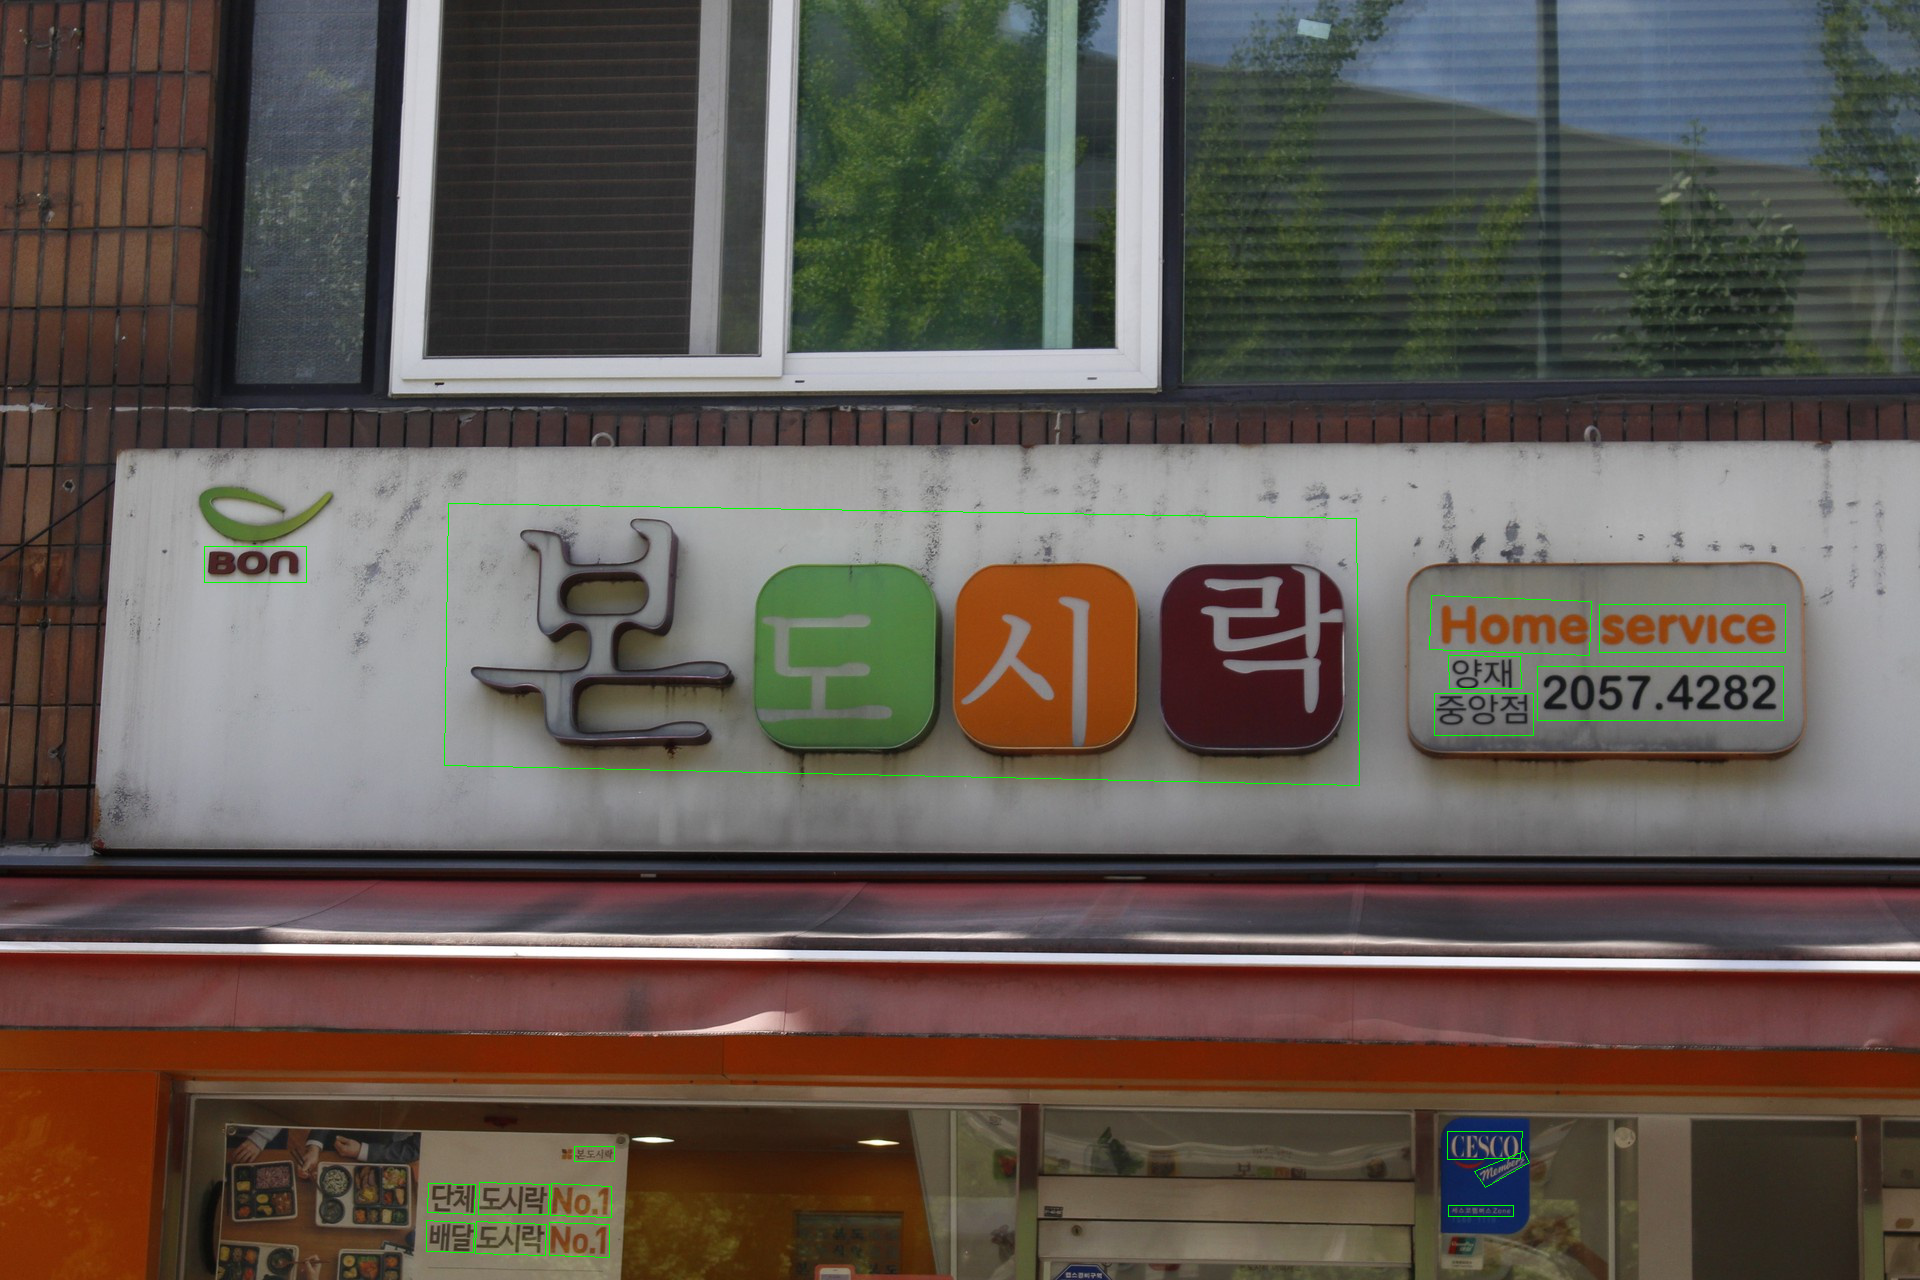

In [2]:
img = Image.open('sample.jpg')
imgdraw = ImageDraw.Draw(img)

bboxes = []
with open('sample.txt', 'r', encoding = 'utf-8-sig') as f :
    data = f.readlines()
    for d in data :
        coords = d.strip().split('\t')[:8]
        coords = [int(c) for c in coords]
        bboxes.append(coords)
        imgdraw.polygon(coords, fill = None, outline = (0,255,0))
        
img

- PAN++에서 나오는 기술을 살펴보자
1. label generation
2. pixel aggregation


---

### label generation
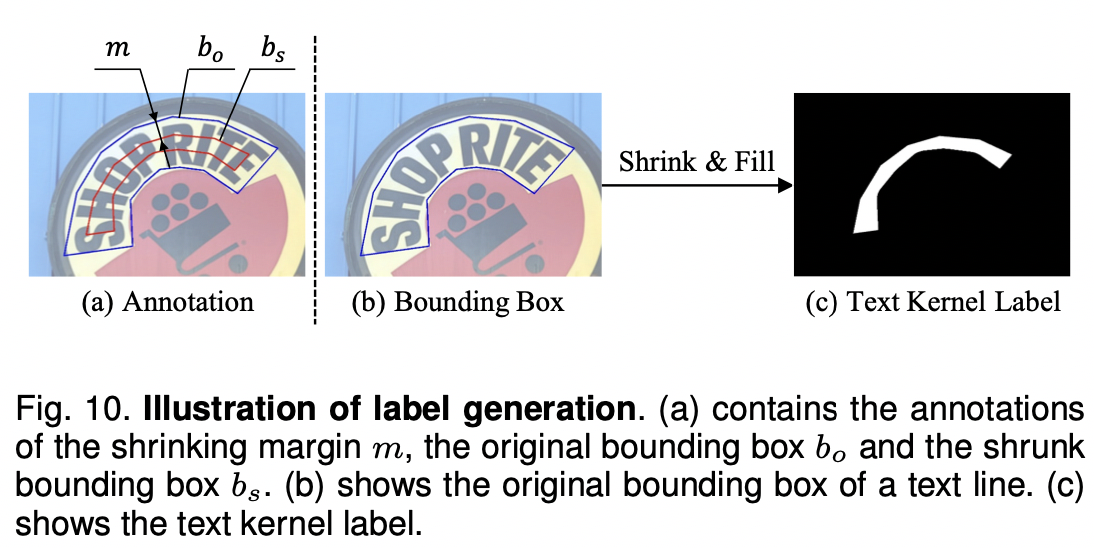

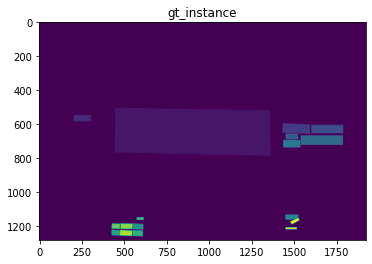

In [23]:
# 코드에 나온대로, read_type == cv2로 진행
img = cv2.imread('sample.jpg')

bboxes = np.array([np.array(bbox).reshape(-1, 2) for bbox in bboxes])


gt_instance = np.zeros(img.shape[0:2], dtype = 'uint8')
# training_mask = np.zeros(img.shape[0:2], dtype = 'uint8')

# 코드에서는 random_scale에 따라 bbox 좌표를 조절하지만 여기선 스킵.

# data preparation에서 준비한 bboxes를 사용해서 contour 그리기
for i in range(bboxes.shape[0]) :
    cv2.drawContours(gt_instance, [bboxes[i]], -1, i+1, -1) # 각 다른 label로 마킹.
plt.show()
plt.title('gt_instance')
plt.imshow(gt_instance)

# 코드에서는 training_mask에 [UNK] 태그가 붙은 텍스트 영역은 0으로 표시함으로써 학습에 반영X. 여기선 스킵


# 이제 gt_kernel을 생성하는 단계
kernel_scale = 0.5
gt_kernels = []
for rate in [kernel_scale] :
    gt_kernel = np.zeros(img.shape)
    kernel_bboxes = shrink(bboxes, rate) # shrink에 대한 내용은 아래에
    for i in range(bboxes.shape[0]) :
        cv2.drawContours(gt_kernel, [kernel_bboxes[i]], -1, 1, -1)
    gt_kernels.append(gt_kernel)

In [24]:
# bboxes들의 영역을 어떻게 shrink하는지 알아보자.

# pyclipper 라이브러리 사용
# 자세한 알고리즘 내용은 http://www.angusj.com/delphi/clipper.php 

def shrink(bboxes, rate, max_shr = 20) :
    rate = rate*rate
    shrinked_bboxes = []
    for bbox in bboxes :
        area = plg.Polygon(bbox).area()
        peri = perimeter(bbox) # 아래에 함수
        
        try :
            pco = pyclipper.PyclipperOffset()
            pco.AddPath(bbox, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
            offset = min(int(area * (1- rate) / (peri + 0.001) + 0.5),
                         max_shr) #TODO: offset이 과도하게 커지는 것을 방지하는데, 줄어든 area에 둘레를 나누는 이유는 뭘까?

            shrinked_bbox = pco.Execute(-offset)
            if len(shrinked_bbox) == 0 :
                shrinked_bboxes.append(bbox)
                continue
            shrinked_bbox = np.array(shrinked_bbox)[0]
            if shrinked_bbox.shape[0] <= 2 :
                shrinked_bboxes.append(bbox)
                continue

            shrinked_bboxes.append(shrinked_bbox)

        except Exception :
            print('area: ', area, 'peri: ', peri)
            shrinked_bboxes.append(bbox)
        
    return shrinked_bboxes
        
def dist(a, b):
    return np.linalg.norm((a - b), ord=2, axis=0)

def perimeter(bbox):
    '''
    bounding box의 둘레
    '''
    peri = 0.0
    for i in range(bbox.shape[0]):
        peri += dist(bbox[i], bbox[(i + 1) % bbox.shape[0]])
    return peri



In [25]:
shrinked_bboxes = np.array(shrink(bboxes, 0.5))

In [26]:
kernel1 = np.zeros(img.shape[:2], 'uint8')
kernel2 = np.zeros(img.shape[:2], 'uint8')


for i in range(bboxes.shape[0]) :
    cv2.drawContours(kernel1, [bboxes[i]], -1, 1, -1)

for i in range(shrinked_bboxes.shape[0]) :
    cv2.drawContours(kernel2, [shrinked_bboxes[i]], -1, 1, -1)

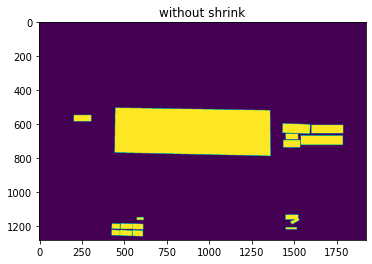

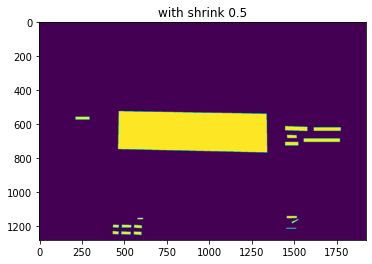

In [27]:
plt.show()
plt.title('without shrink')
plt.imshow(kernel1)

plt.show()
plt.title('with shrink 0.5')
plt.imshow(kernel2)

- 위의 그림보다 텍스트 박스가 조금 줄어든(shrink) 것을 확인할 수 있다.

---

### pixel aggregation
